In [1]:
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.exceptions import NotFittedError

### Importing the data for First Day and First Session

In [4]:
first_day = pd.read_csv("Mobilizer_my_arcade_center_20240715_112813_FirstDay_LTVNumeric.csv")
first_session = pd.read_csv("Mobilizer_my_arcade_center_20240715_112813_FirstSession_LTVNumeric.csv")

### Filtering useless columns and indexing in terms of max_user_first_touch_timestamp

In [7]:
# These columns will be dropped from x_first_day as they are considered useless
model_regex = "impression|reward|banner|starting_version|package|buypackage|purchase|in_app_purchase|iap_purchase"

# First Day Data Filtering
first_day.set_index("max_user_first_touch_timestamp", inplace=True)
first_day.sort_index(inplace=True)
x_first_day = first_day.drop(["user_pseudo_id", "ltv"], axis = 1)
x_first_day.drop(x_first_day.filter(regex=model_regex).columns, axis=1, inplace=True)
y_first_day = first_day['ltv']  # Target value is LTV, it is the y_first_day


# First Session Data Filtering
first_session.set_index("max_user_first_touch_timestamp", inplace=True)
first_session.sort_index(inplace=True)
x_first_session = first_session.drop(["user_pseudo_id", "ltv"], axis = 1)
x_first_session.drop(x_first_session.filter(regex=model_regex).columns, axis=1, inplace=True)
y_first_session = first_session['ltv']

### Remove columns with high correlation 

In [10]:
def high_corr(data, threshold):
    z = data.copy()
    t = z.corr().abs()
    upper = t.where(np.triu(np.ones(t.shape), k=1).astype(bool))
    high = [column for column in upper.columns if any(upper[column] > threshold)]
    z.drop(high, axis=1, inplace=True)
    return z

In [12]:
x_first_session = high_corr(x_first_session, 0.8)
x_first_day = high_corr(x_first_day, 0.8)

### Time Series Split for First Session

In [15]:
tss_first_session = TimeSeriesSplit(n_splits=3)
x_train_tss_first_session, x_test_tss_first_session, y_train_tss_first_session, y_test_tss_first_session = None, None, None, None

for train_index, test_index in tss_first_session.split(x_first_session):
    x_train_tss_first_session = x_first_session.iloc[train_index]
    x_test_tss_first_session = x_first_session.iloc[test_index]
    y_train_tss_first_session = y_first_session.iloc[train_index]
    y_test_tss_first_session = y_first_session.iloc[test_index]

### Time Series Split for First Day 

In [18]:
tss_first_day = TimeSeriesSplit(n_splits=3)
x_train_tss_first_day, x_test_tss_first_day, y_train_tss_first_day, y_test_tss_first_day = None, None, None, None

for train_index, test_index in tss_first_day.split(x_first_session):
    x_train_tss_first_day = x_first_day.iloc[train_index]
    x_test_tss_first_day = x_first_day.iloc[test_index]
    y_train_tss_first_day = y_first_day.iloc[train_index]
    y_test_tss_first_day = y_first_day.iloc[test_index]

### Train-Test Splitting for First Session

In [21]:
x_train_first_session, x_test_first_session, y_train_first_session, y_test_first_session = train_test_split(
    x_first_session, y_first_session, random_state=42, test_size=0.2
)

### Train-Test Splitting for First Day

In [24]:
x_train_first_day, x_test_first_day, y_train_first_day, y_test_first_day = train_test_split(
    x_first_day, y_first_day, random_state=42, test_size=0.2
)

### Evaluating the Performance of the Model

### Plotting function for evaluation

In [28]:
# Function to plot actual vs. predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name, dataset_name):
    plt.figure(figsize=(6, 6))

    # Scatter plot of predicted vs. actual values
    plt.scatter(y_true, y_pred, alpha=0.6)

    # Plot a line of perfect prediction (where y_true == y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color="red", lw=2)

    # Set plot limits (optional, adjust based on your data range)
    plt.xlim(0, 60)
    plt.ylim(0, 60)

    # Add labels and title
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs. Actual Values - {model_name} ({dataset_name})")

    # Display the plot
    plt.show()

### Comparing columns for First Session and First Day

In [31]:
#print("Columns in First Session but not in First Day:", set(x_train_first_session.columns) - set(x_train_first_day.columns))
#print("Columns in First Day but not in First Session:", set(x_train_first_day.columns) - set(x_train_first_session.columns))

### Training Random Forest Regressor and Decision Tree Regressor with Test Train Splitting

Training model: RandomForestRegressor


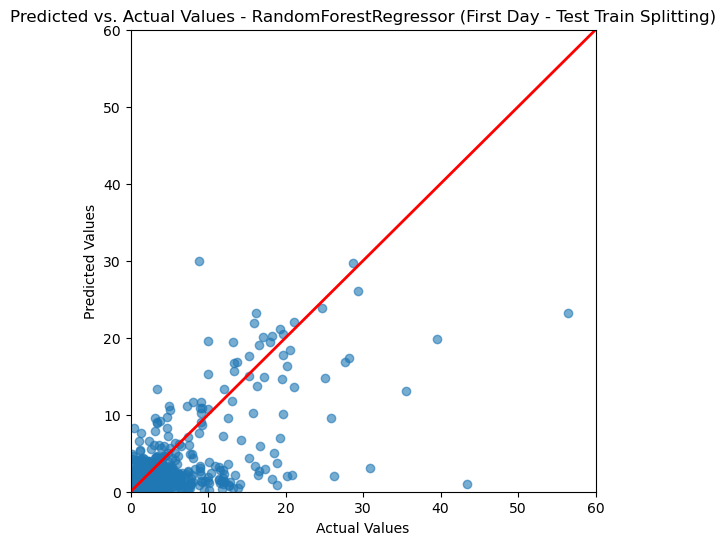

Results for Test Train Splitting RandomForestRegressor - First Day
R2 Score: 0.4599
Mean Squared Error: 7.7116
Mean Absolute Error: 0.8835


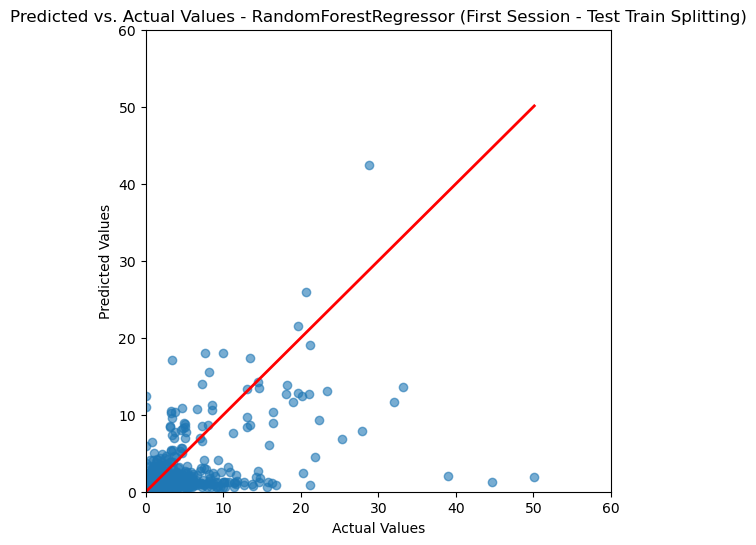

Results for Test Train Splitting RandomForestRegressor - First Session
R2 Score: 0.3065
Mean Squared Error: 5.0152
Mean Absolute Error: 0.9771
Training model: DecisionTreeRegressor


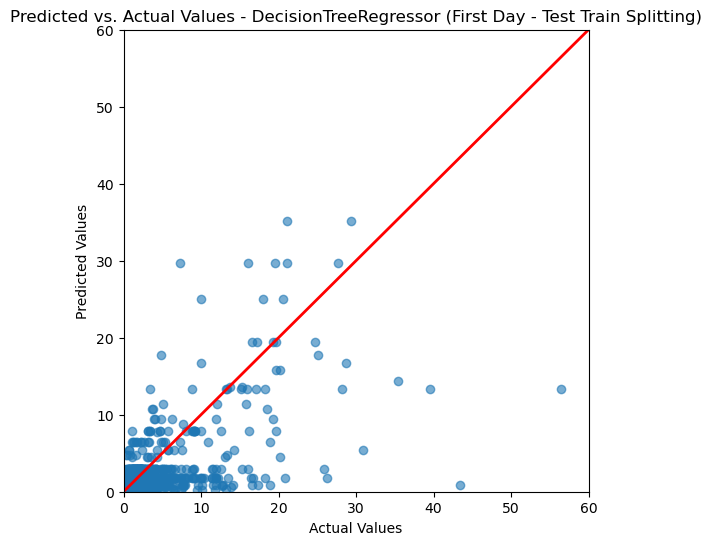

Results for Test Train Splitting DecisionTreeRegressor - First Day
R2 Score: 0.4402
Mean Squared Error: 7.9923
Mean Absolute Error: 0.9422


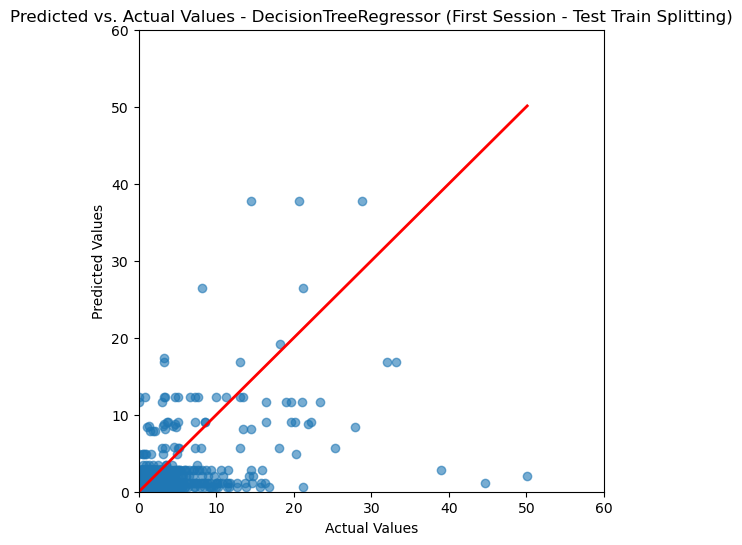

Results for Test Train Splitting DecisionTreeRegressor - First Session
R2 Score: 0.2462
Mean Squared Error: 5.4507
Mean Absolute Error: 1.0046


In [34]:
models = {
    "RandomForestRegressor": {
        "model": RandomForestRegressor(n_estimators=50, max_depth=7, min_samples_split=10, criterion="squared_error", random_state=42),
    },
    "DecisionTreeRegressor": {
        "model": DecisionTreeRegressor(min_samples_split=20, max_depth=6, criterion="squared_error", min_samples_leaf=10, random_state=42),
    }
}

# Loop through each model and train
for model_name, model_info in models.items():
    print(f"Training model: {model_name}")

    model = model_info['model']

    # Train the model on the first-day dataset
    model.fit(x_train_first_day, y_train_first_day)

    # Evaluate on the first-day dataset
    y_pred_first_day = model.predict(x_test_first_day)
    plot_actual_vs_predicted(y_test_first_day, y_pred_first_day, model_name, "First Day - Test Train Splitting")
    r2_first_day = r2_score(y_test_first_day, y_pred_first_day)
    mse_first_day = mean_squared_error(y_test_first_day, y_pred_first_day)
    mae_first_day = mean_absolute_error(y_test_first_day, y_pred_first_day)

    print(f"Results for Test Train Splitting {model_name} - First Day")
    print(f"R2 Score: {r2_first_day:.4f}")
    print(f"Mean Squared Error: {mse_first_day:.4f}")
    print(f"Mean Absolute Error: {mae_first_day:.4f}")
    print("="*50)

    # Train the model on the first-session dataset
    model.fit(x_train_first_session, y_train_first_session)

    # Evaluate on the first-session dataset
    y_pred_first_session = model.predict(x_test_first_session)
    plot_actual_vs_predicted(y_test_first_session, y_pred_first_session, model_name, "First Session - Test Train Splitting")
    r2_first_session = r2_score(y_test_first_session, y_pred_first_session)
    mse_first_session = mean_squared_error(y_test_first_session, y_pred_first_session)
    mae_first_session = mean_absolute_error(y_test_first_session, y_pred_first_session)

    print(f"Results for Test Train Splitting {model_name} - First Session")
    print(f"R2 Score: {r2_first_session:.4f}")
    print(f"Mean Squared Error: {mse_first_session:.4f}")
    print(f"Mean Absolute Error: {mae_first_session:.4f}")
    print("="*50)
    

### Training Random Forest Regressor and Decision Tree Regressor with Time Series Splitting

Training model: RandomForestRegressor


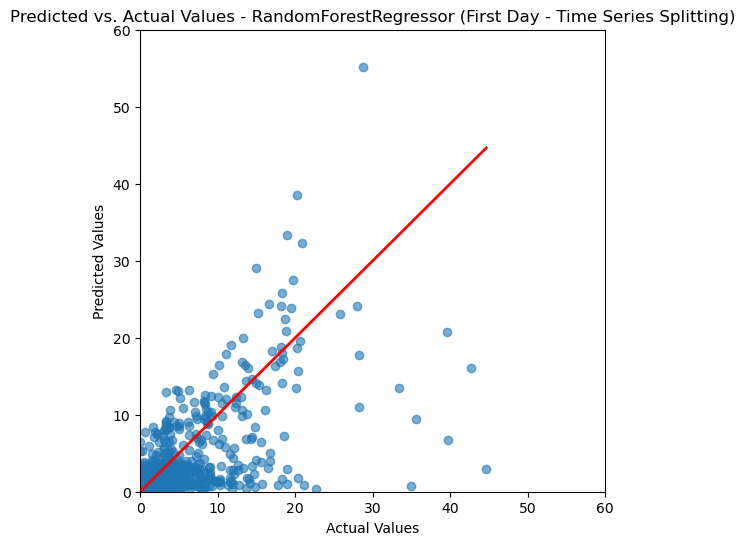

Results for Time Series Splitting RandomForestRegressor - First Day
R2 Score: 0.4762
Mean Squared Error: 4.7342
Mean Absolute Error: 0.8785


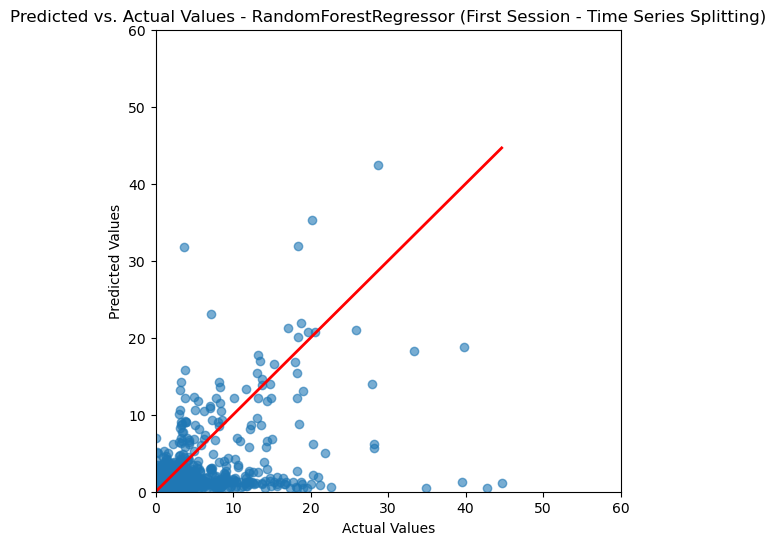

Results for Time Series Splitting RandomForestRegressor - First Session
R2 Score: 0.2593
Mean Squared Error: 6.4876
Mean Absolute Error: 1.0868
Training model: DecisionTreeRegressor


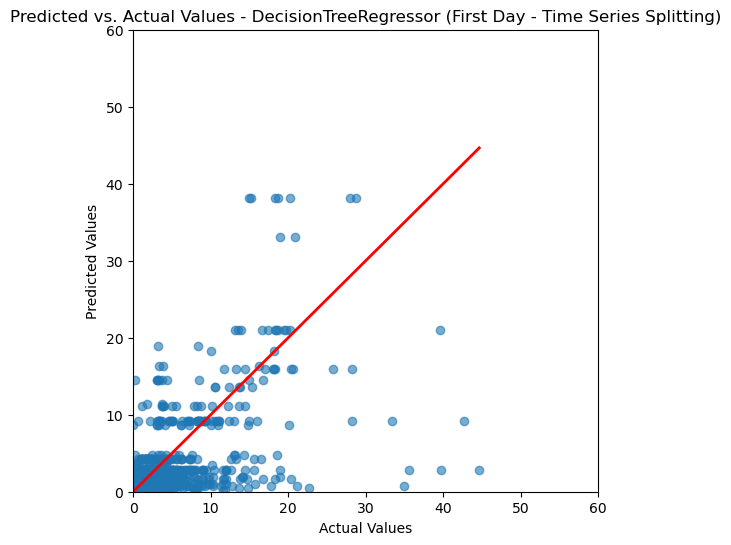

Results for Time Series Splitting DecisionTreeRegressor - First Day
R2 Score: 0.3638
Mean Squared Error: 5.7503
Mean Absolute Error: 0.9373


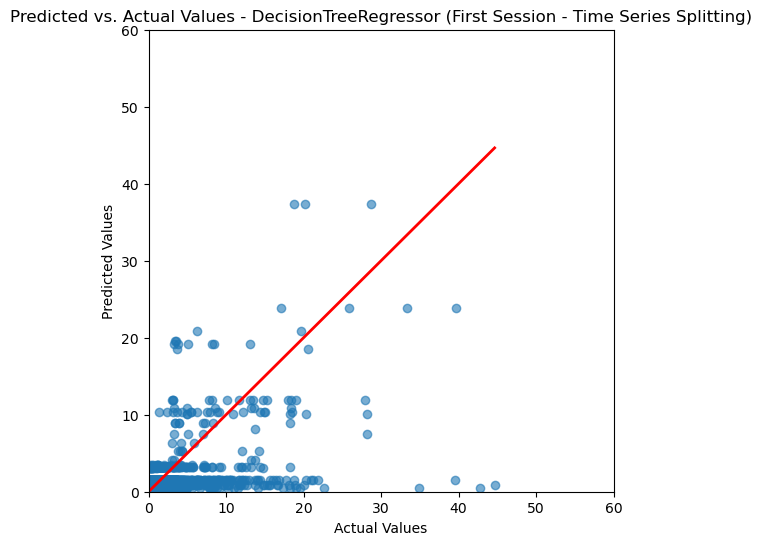

Results for Time Series Splitting DecisionTreeRegressor - First Session
R2 Score: 0.2282
Mean Squared Error: 6.7598
Mean Absolute Error: 1.1198


In [37]:
models = {
    "RandomForestRegressor": {
        "model": RandomForestRegressor(n_estimators=50, max_depth=7, min_samples_split=10, criterion="squared_error", random_state=42),
    },
    "DecisionTreeRegressor": {
        "model": DecisionTreeRegressor(min_samples_split=20, max_depth=6, criterion="squared_error", min_samples_leaf=10, random_state=42),
    }
}

# Loop through each model and train
for model_name, model_info in models.items():
    print(f"Training model: {model_name}")

    model = model_info['model']

    # Train the model on the first-day dataset
    model.fit(x_train_tss_first_day, y_train_tss_first_day)

    # Evaluate on the first-day dataset
    y_pred_tss_first_day = model.predict(x_test_tss_first_day)
    plot_actual_vs_predicted(y_test_tss_first_day, y_pred_tss_first_day, model_name, "First Day - Time Series Splitting")
    r2_first_day = r2_score(y_test_tss_first_day, y_pred_tss_first_day)
    mse_first_day = mean_squared_error(y_test_tss_first_day, y_pred_tss_first_day)
    mae_first_day = mean_absolute_error(y_test_tss_first_day, y_pred_tss_first_day)

    print(f"Results for Time Series Splitting {model_name} - First Day")
    print(f"R2 Score: {r2_first_day:.4f}")
    print(f"Mean Squared Error: {mse_first_day:.4f}")
    print(f"Mean Absolute Error: {mae_first_day:.4f}")
    print("="*50)

    # Train the model on the first-session dataset
    model.fit(x_train_tss_first_session, y_train_tss_first_session)

    # Evaluate on the first-session dataset
    y_pred_tss_first_session = model.predict(x_test_tss_first_session)
    plot_actual_vs_predicted(y_test_tss_first_session, y_pred_tss_first_session, model_name, "First Session - Time Series Splitting")
    r2_first_session = r2_score(y_test_tss_first_session, y_pred_tss_first_session)
    mse_first_session = mean_squared_error(y_test_tss_first_session, y_pred_tss_first_session)
    mae_first_session = mean_absolute_error(y_test_tss_first_session, y_pred_tss_first_session)

    print(f"Results for Time Series Splitting {model_name} - First Session")
    print(f"R2 Score: {r2_first_session:.4f}")
    print(f"Mean Squared Error: {mse_first_session:.4f}")
    print(f"Mean Absolute Error: {mae_first_session:.4f}")
    print("="*50)

### LGBM Regression with Test Train Splitting for First Session

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2498
[LightGBM] [Info] Number of data points in the train set: 14866, number of used features: 97
[LightGBM] [Info] Start training from score 1.239505


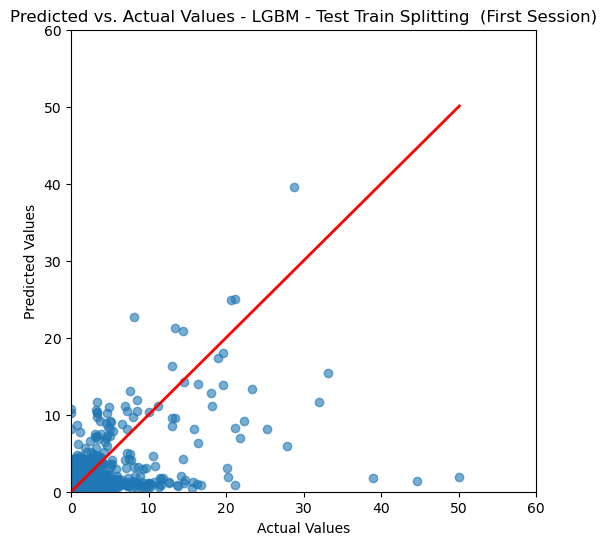

Results for LGBM Regressor (Test Train Splitting) - First Session
R2 Score: 0.2933
Mean Squared Error: 5.1106
Mean Absolute Error: 0.9662


In [40]:
scaler = StandardScaler()
#Fit the StandardScaler to the training data 
scaler.fit(x_test_first_session)
# transform both the training and validation data 
x_train_first_session = scaler.transform(x_train_first_session)
x_test_first_session = scaler.transform(x_test_first_session)


# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(x_train_first_session, label=y_train_first_session)

# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(x_test_first_session, label=y_test_first_session, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = bst.predict(x_test_first_session)
plot_actual_vs_predicted(y_test_first_session, y_pred, "LGBM - Test Train Splitting ", "First Session")
r2_first_session = r2_score(y_test_first_session, y_pred)
mse_first_session = mean_squared_error(y_test_first_session, y_pred)
mae_first_session = mean_absolute_error(y_test_first_session, y_pred)

print(f"Results for LGBM Regressor (Test Train Splitting) - First Session")
print(f"R2 Score: {r2_first_session:.4f}")
print(f"Mean Squared Error: {mse_first_session:.4f}")
print(f"Mean Absolute Error: {mae_first_session:.4f}")
print("=" * 50)

### LGBM Regressor with Time Series Splitting for First Session

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 13938, number of used features: 97
[LightGBM] [Info] Start training from score 1.191256


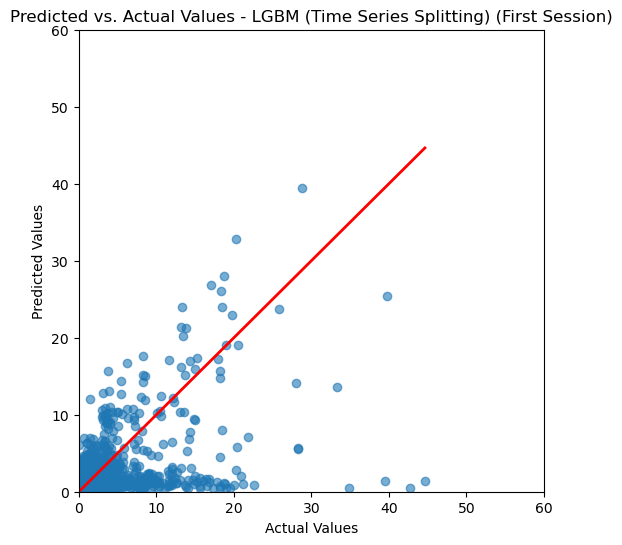

Results for LGBM (Time Series Splitting)- First Session
R2 Score: 0.2681
Mean Squared Error: 6.4101
Mean Absolute Error: 1.1059


In [42]:
scaler = StandardScaler()
#Fit the StandardScaler to the training data 
scaler.fit(x_test_tss_first_session)
# transform both the training and validation data 
x_train_tss_first_session = scaler.transform(x_train_tss_first_session)
x_test_tss_first_session = scaler.transform(x_test_tss_first_session)


# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(x_train_tss_first_session, label=y_train_tss_first_session)

# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(x_test_tss_first_session, label=y_test_tss_first_session, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = bst.predict(x_test_tss_first_session)
plot_actual_vs_predicted(y_test_tss_first_session, y_pred, "LGBM - Time Series Splitting ", "First Session")
r2_first_session = r2_score(y_test_tss_first_session, y_pred)
mse_first_session = mean_squared_error(y_test_tss_first_session, y_pred)
mae_first_session = mean_absolute_error(y_test_tss_first_session, y_pred)

print(f"Results for LGBM Regressor (Time Series Splitting)- First Session")
print(f"R2 Score: {r2_first_session:.4f}")
print(f"Mean Squared Error: {mse_first_session:.4f}")
print(f"Mean Absolute Error: {mae_first_session:.4f}")
print("=" * 50)

### LGBM Regression with Test Train Splitting for First Day

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6332
[LightGBM] [Info] Number of data points in the train set: 14974, number of used features: 132
[LightGBM] [Info] Start training from score 1.193625


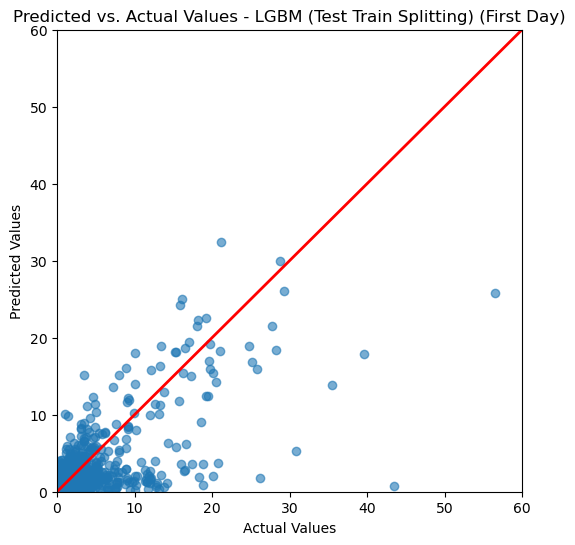

Results for LGBM (Test Train Splitting) - First Day
R2 Score: 0.4790
Mean Squared Error: 7.4387
Mean Absolute Error: 0.8666


In [42]:
scaler = StandardScaler()
#Fit the StandardScaler to the training data 
scaler.fit(x_test_first_day)
# transform both the training and validation data 
x_train_first_day = scaler.transform(x_train_first_day)
x_test_first_day = scaler.transform(x_test_first_day)


# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(x_train_first_day, label=y_train_first_day)

# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(x_test_first_day, label=y_test_first_day, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = bst.predict(x_test_first_day)
plot_actual_vs_predicted(y_test_first_day, y_pred, "LGBM (Test Train Splitting)", "First Day")
r2_first_session = r2_score(y_test_first_day, y_pred)
mse_first_session = mean_squared_error(y_test_first_day, y_pred)
mae_first_session = mean_absolute_error(y_test_first_day, y_pred)

print(f"Results for LGBM (Test Train Splitting) - First Day")
print(f"R2 Score: {r2_first_session:.4f}")
print(f"Mean Squared Error: {mse_first_session:.4f}")
print(f"Mean Absolute Error: {mae_first_session:.4f}")
print("=" * 50)

### LGBM Regression with Time Series Splitting for First Day

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6261
[LightGBM] [Info] Number of data points in the train set: 13938, number of used features: 130
[LightGBM] [Info] Start training from score 1.184842


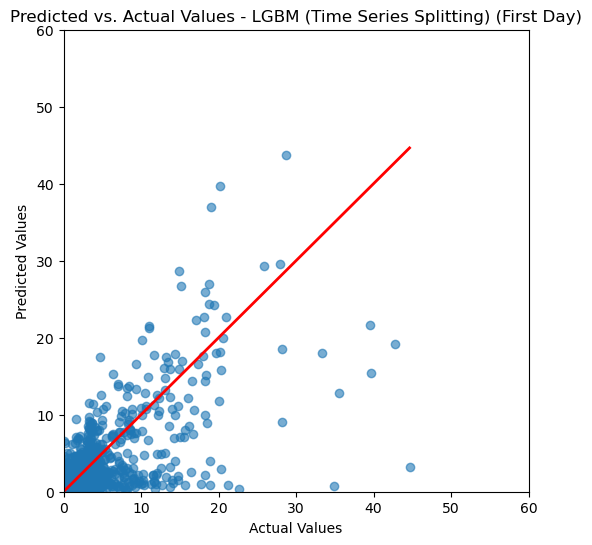

Results for LGBM (Time Series Splitting) - First Day
R2 Score: 0.5066
Mean Squared Error: 4.4595
Mean Absolute Error: 0.8712


In [45]:
scaler = StandardScaler()
#Fit the StandardScaler to the training data 
scaler.fit(x_test_tss_first_day)
# transform both the training and validation data 
x_train_tss_first_day = scaler.transform(x_train_tss_first_day)
x_test_tss_first_day = scaler.transform(x_test_tss_first_day)


# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(x_train_tss_first_day, label=y_train_tss_first_day)

# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(x_test_tss_first_day, label=y_test_tss_first_day, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = bst.predict(x_test_tss_first_day)
plot_actual_vs_predicted(y_test_tss_first_day, y_pred, "LGBM (Time Series Splitting)", "First Day")
r2_first_session = r2_score(y_test_tss_first_day, y_pred)
mse_first_session = mean_squared_error(y_test_tss_first_day, y_pred)
mae_first_session = mean_absolute_error(y_test_tss_first_day, y_pred)

print(f"Results for LGBM (Time Series Splitting) - First Day")
print(f"R2 Score: {r2_first_session:.4f}")
print(f"Mean Squared Error: {mse_first_session:.4f}")
print(f"Mean Absolute Error: {mae_first_session:.4f}")
print("=" * 50)